# DTB Job Shadowning Task
**Predicting Customer Churn Using Machine Learning**

**Task**: Collaboratively work together to develop a machine learning model to predict customer churn ‚Äì that is, determine the likelihood that a customer will leave the bank based on behavioral and financial attributes.

>**Team Members**:
>
> Chesia Anyika &
>
> Cyrus Cheserek


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step 1: Environment Setup & Data Importation
> This section focuses on preprocessing the dataset to ensure it is clean and ready for exploratory data analysis (EDA). This includes verifying and correcting the data types of each variable, as well as handling missing values using appropriate imputation techniques."

In [ ]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import necessary libraries
import pandas as pd #data manipulation
import numpy as np #mathematical computing
import matplotlib.pyplot as plt #visualisation
import seaborn as sns #visualisation
from scipy.stats import chi2_contingency #chi-square test analysis
from scipy.stats import pearsonr #pvalues for chi-square tests
from sklearn.impute import KNNImputer #knn imputation
from sklearn.preprocessing import OrdinalEncoder #ordinal encoding

# model training and evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

# Artificial neural Network libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Set style
sns.set(style="whitegrid")

We then imported the provided `customer_churn_data_ke.csv` dataset into the notebook, through google drive.

In [ ]:
# mount drive (data importation)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data importation - main dataset
df = pd.read_csv('/content/drive/MyDrive/DTB_customer_churn/customer_churn_data_ke.csv')

# view the first five entries
df.head(5)

customer_id  age  credit_score  account_balance_kes  num_transactions  \
0    3374VTTC   24         562.0             32562.91                17   
1    3731ESJR   59         732.0             13991.60                 7   
2    5343VTCX   60         756.0             43351.49                16   
3    8690BGUV   24         660.0              3365.44                 5   
4    1987NUSS   25         571.0            130834.67                11   

   loan_amount_kes  tenure_in_months  num_products  days_since_last_login  \
0        299014.76                59             4                   43.0   
1        149475.80                58             3                   42.0   
2         97826.78                55             3                   54.0   
3         24054.76                25             1                   88.0   
4         15204.21                52             2                    7.0   

   customer_support_calls  ...  num_logins  cr_card_usage_ratio  \
0                       4  ...          14                 0.75   
1                       3  ...          14                 0.08   
2                       1  ...          15                 0.65   
3                       2  ...           8                 0.70   
4                       2  ...          11                 0.74   

   mortgage_balance_kes  investment_balance_kes  education_level  \
0               9826.92                80231.82        Secondary   
1              36095.05                16300.76          Primary   
2             200043.52                85765.37          Masters   
3             180079.75                88896.06         Bachelor   
4             150013.59               127158.24         Bachelor   

   marital_status employment_status        region marketing_engagement churn  
0         Widowed     Self-Employed       Baringo               Medium     0  
1        Divorced          Employed    West Pokot                 High     0  
2        Divorced        Unemployed         Kitui                  Low     0  
3        Divorced          Employed        Nakuru                 High     0  
4        Divorced          Employed  Taita-Taveta                 High     0  

[5 rows x 22 columns]

In [ ]:
# examine the shape of the dataset
df.shape

(12345, 22)

The shape of the dataset reveals that it is comprised of:
- 22 columns, reperesnting different customer attributes
- 12345 row entries, representing unique customers.

A supplementary dataset (`data_dictionary_churn_data.xlsx`) was provided to explain what each attribute column represents, and is as follows:



In [ ]:
# data importation
dictionary = pd.read_excel('/content/drive/MyDrive/DTB_customer_churn/data_dictionary_churn_data.xlsx')

# view all entries
dictionary

Column Name Data Type  \
0                 customer_id    string   
1                         age       int   
2                credit_score     float   
3         account_balance_kes     float   
4            num_transactions       int   
5             loan_amount_kes     float   
6            tenure_in_months       int   
7                num_products       int   
8       days_since_last_login     float   
9      customer_support_calls       int   
10                 income_kes     float   
11  avg_transaction_value_kes     float   
12                 num_logins       int   
13        cr_card_usage_ratio     float   
14       mortgage_balance_kes     float   
15     investment_balance_kes     float   
16            education_level    string   
17             marital_status    string   
18          employment_status    string   
19                     region    string   
20       marketing_engagement    string   
21                      churn       int   

                                          Description  
0                 Unique identifier for each customer  
1                             Customer's age in years  
2   Credit score ranging from 300 to 850 (may cont...  
3      Current balance in customer's account (in KES)  
4         Number of transactions made by the customer  
5                      Principal loan amount (in KES)  
6                      Duration of the loan in months  
7    Number of bank products consumed by the customer  
8   Days since the customer last logged in to the ...  
9   Number of times the customer called customer e...  
10  Estimated monthly income of the customer (in KES)  
11             Average value per transaction (in KES)  
12  Number of times the customer logged in to the ...  
13  Ratio of used credit card limit to the total l...  
14              Outstanding mortgage balance (in KES)  
15   Investment balance held by the customer (in KES)  
16  Highest level of education attained by the cus...  
17  Marital status of the customer ['Single', 'Mar...  
18  Current employment status of the customer ['Em...  
19                     Customer's region of residence  
20  Level of engagement with marketing campaigns [...  
21   Indicates if the customer churned (1) or not (0)

---
## Step 2: Data Preprocessing
>This section focuses on preprocessing the dataset to ensure it is clean and ready for exploratory data analysis (EDA). This includes verifying and correcting the data types of each variable, as well as handling missing values using appropriate imputation techniques.


### 1. Data types
We confirmed whether the datatypes of the main dataset matched those stipulated in the data dictionary.

In [ ]:
# Get actual dtypes from the dataframe
actual_dtypes = df.dtypes.rename('Actual Data Type')

# Merge with data dictionary
dtype_comparison = dictionary.set_index('Column Name').join(actual_dtypes, on='Column Name')

# Show comparison
dtype_comparison[['Data Type', 'Actual Data Type']]

Data Type Actual Data Type
Column Name                                         
customer_id                  string           object
age                             int            int64
credit_score                  float          float64
account_balance_kes           float          float64
num_transactions                int            int64
loan_amount_kes               float          float64
tenure_in_months                int            int64
num_products                    int            int64
days_since_last_login         float          float64
customer_support_calls          int            int64
income_kes                    float          float64
avg_transaction_value_kes     float          float64
num_logins                      int            int64
cr_card_usage_ratio           float          float64
mortgage_balance_kes          float          float64
investment_balance_kes        float          float64
education_level              string           object
marital_status               string           object
employment_status            string           object
region                       string           object
marketing_engagement         string           object
churn                           int            int64

There are no discrepancies in the stated and actual datatypes.

### 3. Missing Values
We checked for missing values to determine which columns have missing values, the distribution of these missing values, and the type of missingness exhibited. This will inform which method we use to fill in these missing values.

In [ ]:
# Check missing values per column
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Combine into a DataFrame
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing %': missing_percentage.round(2)
})

# Show only columns with missing values
missing_df[missing_df['Missing Values'] > 0]

Missing Values  Missing %
credit_score                     1234       10.0
days_since_last_login             617        5.0

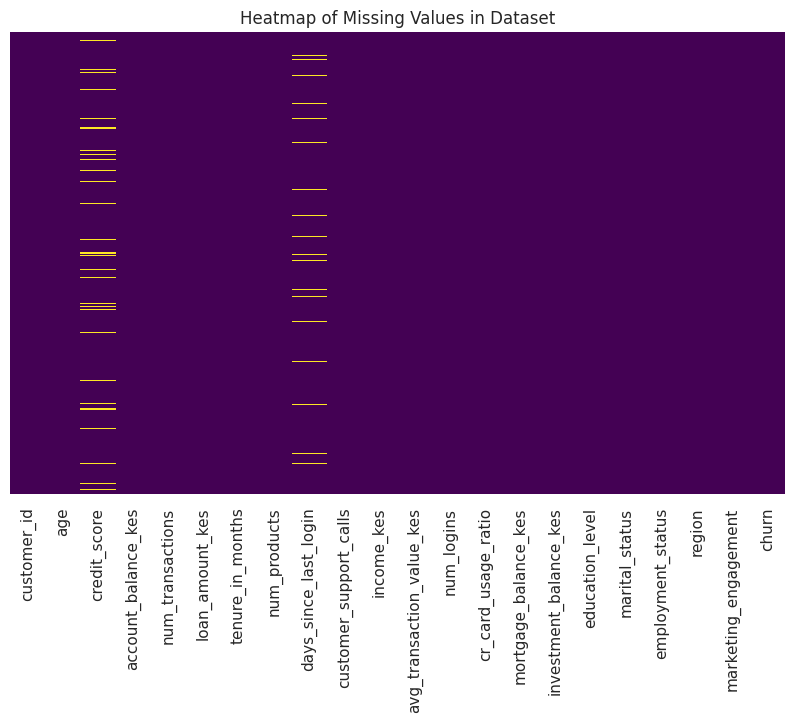

In [ ]:
#Missing values heat map
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Heatmap of Missing Values in Dataset")
plt.show()

**Interpretation**

The Missing Values appear to be either:
- **Missing Completely at Random (MCAR)** (Missing values occur randomly, with no relationship to observed or unobserved data)
- **Missing at Random (MAR)** (Missing values depend on observed data but not on unobserved data).

This is because:
- **No systematic clustering** : The missing values do not form any obvious patterns (e.g., all missing values in one row or column). This suggests that the missingness is not MNAR (Missing not at random).
- **Low percentage of missing values** : Since only a few columns (credit_score and days_since_last_login) have missing values, and those values are sparse, it‚Äôs more likely that the missingness is either MCAR or MAR .

Further analysis:

Additional analysis (e.g., **checking correlations between missingness and other variables**), is necessary in order to definitively conclude whether it‚Äôs MCAR or MAR.

#### Correlation Analysis - Numeric Variables


In [ ]:
# --- Check if missingness in 'credit_score' correlates with other variables ---
# 1. Create missing indicator
df['credit_score_missing'] = df['credit_score'].isnull().astype(int)

# 2. Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# 3. Now compute correlation
corr = numeric_df.corr()

# --- Check if missingness in 'days_since_last_login' correlates with other variables ---

# 1. Create missing indicator for 'days_since_last_login'
df['days_since_last_login_missing'] = df['days_since_last_login'].isnull().astype(int)

# 2. Select only numeric columns for correlation (again)
numeric_df = df.select_dtypes(include=[np.number])

# 3. Compute correlation matrix
corr = numeric_df.corr()

In [ ]:
# List of columns to drop
to_drop = ['credit_score_missing', 'days_since_last_login_missing']

# Extract and clean correlations
credit_corr = corr['credit_score_missing'].drop(to_drop)
login_corr = corr['days_since_last_login_missing'].drop(to_drop)

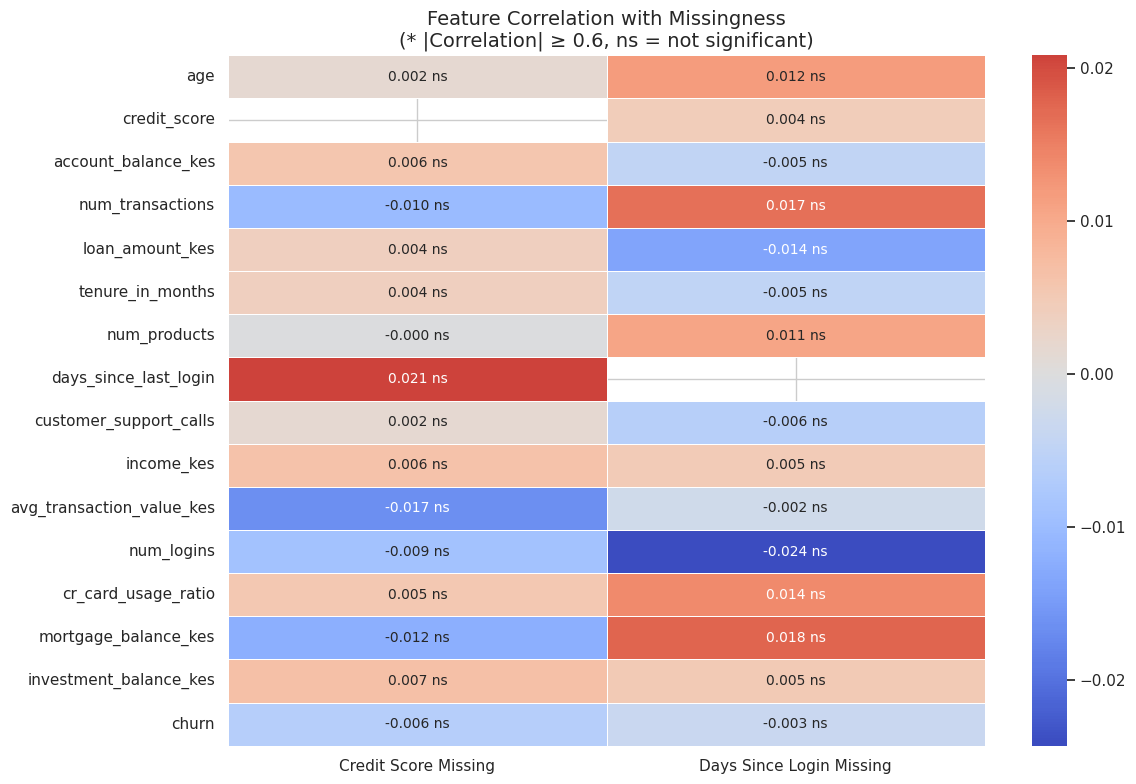

In [ ]:
# Convert to DataFrames for heatmap
credit_df = credit_corr.to_frame(name='Credit Score Missing')
login_df = login_corr.to_frame(name='Days Since Login Missing')

# Combine into one DataFrame for heatmap
combined_df = pd.concat([credit_df, login_df], axis=1)

# Create label matrix for annotations
label_df = combined_df.copy()

def get_label(val):
    if abs(val) >= 0.6:
        return f'{val:.3f} *'
    else:
        return f'{val:.3f} ns'

for col in combined_df.columns:
    label_df[col] = label_df[col].apply(get_label)

# Plot side-by-side heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(
    combined_df,
    annot=label_df,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Feature Correlation with Missingness\n(* |Correlation| ‚â• 0.6, ns = not significant)", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpretation**

For the above Correlation Analysis, we considered any values $v > 0.6$ as statistically significant in the pattern of missigness for either of the two target variables. (rule of thumb threshold)

- None of the numerical attributes were found to have a statistically significant impact on the missing values in both the `credit_score` or `days_since_last_login` variables.

#### Chi-Square Analysis - Categorical Variables

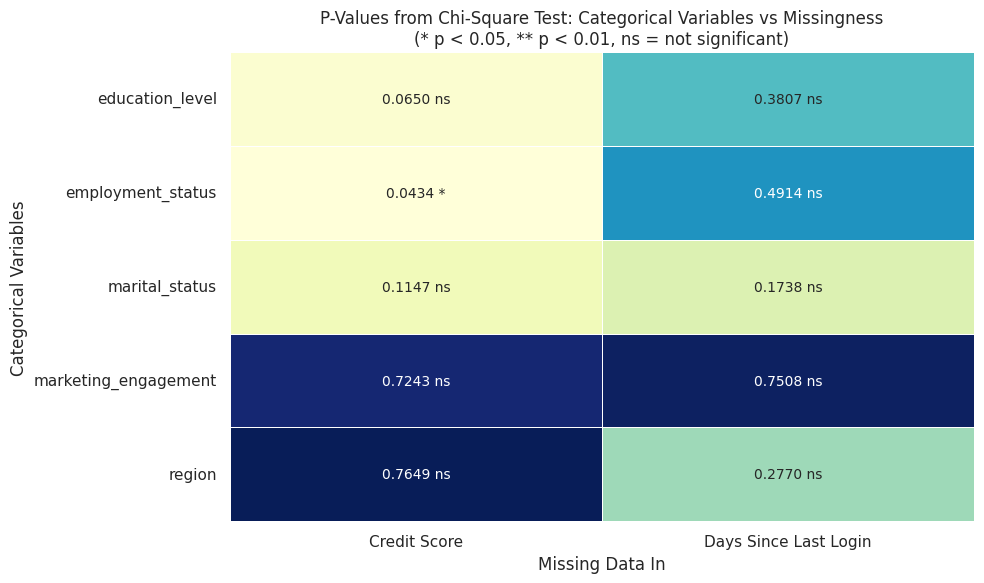

In [ ]:
# --- Step 1: Create missing indicators ---
df['credit_score_missing'] = df['credit_score'].isnull().astype(int)
df['days_since_last_login_missing'] = df['days_since_last_login'].isnull().astype(int)

# --- Step 2: Define function to compute chi-square p-value ---
def chi_square_pvalue(df, cat_col, target_col):
    contingency_table = pd.crosstab(df[cat_col], df[target_col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# --- Step 3: Run Chi-Square tests for both missing indicators ---
categorical_vars = ['education_level', 'marital_status', 'employment_status', 'region', 'marketing_engagement']
targets = ['credit_score_missing', 'days_since_last_login_missing']

results = []

for target in targets:
    for cat_var in categorical_vars:
        p_val = chi_square_pvalue(df, cat_var, target)
        results.append({
            'Missing Variable': target.replace('_missing', '').replace('_', ' ').title(),
            'Categorical Variable': cat_var,
            'P-Value': p_val
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Reshape for heatmap
pivot_df = results_df.pivot(index='Categorical Variable', columns='Missing Variable', values='P-Value')

# Create a significance label matrix for annotations
label_df = pivot_df.copy()

def get_significance_label(p):
    if p < 0.01:
        return f'{p:.4f} **'
    elif p < 0.05:
        return f'{p:.4f} *'
    else:
        return f'{p:.4f} ns'

for col in label_df.columns:
    for idx in label_df.index:
        label_df.loc[idx, col] = get_significance_label(pivot_df.loc[idx, col])

# --- Step 4: Visualize the p-values with significance labels ---
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=label_df, fmt='', cmap="YlGnBu", linewidths=0.5, cbar=False, annot_kws={"size": 10})
plt.title("P-Values from Chi-Square Test: Categorical Variables vs Missingness\n(* p < 0.05, ** p < 0.01, ns = not significant)")
plt.ylabel("Categorical Variables")
plt.xlabel("Missing Data In")
plt.tight_layout()
plt.show()

**Interpretation**

In the above Chi-Square test analysis, any P-values $p < 0.05$ were considered statistically significant in the pattern of missingness for zeither of the two target variables.

- Only the `employment_status` variable was found to have a statistically significant relationship with the pattern of missingness in the `credit_score` variable.
- No variable was found to be statistically significant with the pattern of missingness in the `days-since-last-login` variable.



**Association between `employment_status` and `credit_score` missing values**

We can further visualise the proportion of missing values per category within the `employment_status` variable, to understand which customers are more likely to have missing `credit_score` values.


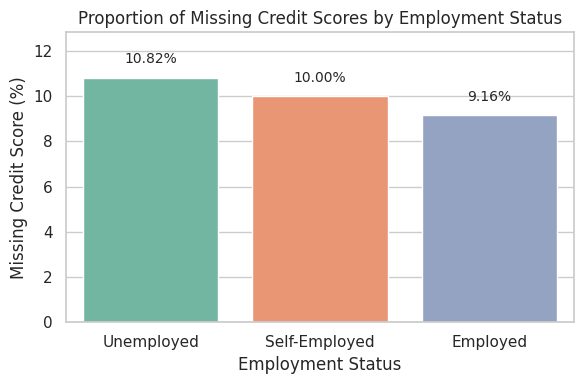

In [ ]:
# --- Step 1: Create a new column indicating if credit_score is missing ---
df['credit_score_missing'] = df['credit_score'].isnull()

# --- Step 2: Group by employment_status and compute % of missing credit scores ---
missing_by_employment = df.groupby('employment_status')['credit_score_missing'].mean().sort_values(ascending=False)

# Convert to percentage
missing_by_employment_pct = missing_by_employment * 100

# --- Step 3: Plot with percentage labels ---
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x=missing_by_employment_pct.index, y=missing_by_employment_pct.values, palette='Set2')
plt.title('Proportion of Missing Credit Scores by Employment Status')
plt.ylabel('Missing Credit Score (%)')
plt.xlabel('Employment Status')
plt.ylim(0, max(missing_by_employment_pct.values) + 2)  # Add some space for labels

# Add percentage labels on top of bars
for index, value in enumerate(missing_by_employment_pct.values):
    barplot.text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

**Interpretation**

Customers in the `Unemployed` category of the `employment_status` variable are most likely to have missing values in the `credit_score` variable, and this is considered **statistically significant**.


#### Summary of Findings (Missing Values Analysis)

| Variable                  | Missingness Related To               | P-value / Correlation | Conclusion                        | Recommended Imputation                      |
|---------------------------|--------------------------------------|------------------------|-----------------------------------|---------------------------------------------|
| `credit_score`            | `employment_status` (Chi-Square p = 0.043) | Significant             | MAR (Missing at Random)          | KNN Imputer, IterativeImputer, or Predictive Model |
| `days_since_last_login`   | No categorical or numerical variable | Not significant        | MCAR (Missing Completely at Random) | Mean/Median Imputation                      |


Thus we chose to run:
- KNN Imputation for `credit_score`
- Mean imputation for `days_since_last_login`


#### Imputation
We create a feature matrix `X` whose missing values will be imputed, excluding `customer_id` variable as it is not predictive. We also exclude the target variable `churn` and store it in the variable `y`.

In [ ]:
# Feature Matrix X (all variables EXCEPT 'churn & customer_id')
X = df.drop(columns=['churn', 'customer_id', 'credit_score_missing', 'days_since_last_login_missing'])  # customer_id is not predictive

# Target vector y
y = df['churn']

In [ ]:
# For credit_score (MAR): Use KNN imputation
knn_imputer = KNNImputer(n_neighbors=5) #why
X[['credit_score']] = knn_imputer.fit_transform(X[['credit_score']])

# For days_since_last_login (MCAR): Use median imputation
X['days_since_last_login'] = X['days_since_last_login'].fillna(X['days_since_last_login'].median())

In [ ]:
# Step 1: Check missing values per column in X
missing_values_X = X.isnull().sum()
missing_percentage_X = (X.isnull().sum() / len(X)) * 100

# Step 2: Combine into a DataFrame
missing_df_X = pd.DataFrame({
    'Missing Values': missing_values_X,
    'Missing %': missing_percentage_X.round(2)
})

# Missing values heatmap for X
plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Heatmap of Missing Values in Feature Matrix (X)")
plt.show()

The heat map shows that there are no missing values in our feature matrix `X`.

---
## Step 3: Feature Engineering & Exploratory Data Analysis
>This section focuses on **Exploratory Data Analysis (EDA) and Feature Engineering**, combining both visual and statistical techniques to understand the dataset and prepare it for modeling. The goal is to:
>
>- Analyze the distribution and relationships between features and the target variable (churn)
>
>- Encode categorical variables using appropriate methods such as One-Hot Encoding and Ordinal Encoding
>
>- Select the most relevant features for modeling using correlation matrices , Chi-Square tests , and Logistic Regression coefficients
>
>These steps ensure that the dataset is not only clean but also optimized for training predictive models.



### Distribution of `churn` Variable

First, we visualised the distribution of the `churn` variable for a better understanding of the target variable.

In [ ]:
# Get value counts
churn_counts = y.value_counts().sort_index()

# Map labels for clarity
churn_counts.index = churn_counts.index.map({0: 'Retained (0)', 1: 'Churned (1)'})

# Calculate percentages
total = churn_counts.sum()
churn_percentages = (churn_counts / total) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Category': churn_counts.index,
    'Count': churn_counts.values,
    'Percentage': churn_percentages.values
})

# Plotting
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Category', y='Count', data=plot_df, palette='Set2')

# Add percentage labels on bars
for index, row in plot_df.iterrows():
    barplot.text(
        index,
        row['Count'] + 0.02 * max(plot_df['Count']),  # slight offset
        f"{row['Percentage']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Formatting
plt.title('Customer Churn Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpretation**
- The target variable is binary with the outcomes `retained` and `churned`, which are encoded as $0$ and $1$ respectively in the dataframe.
- The variable is **unbalanced**, which means certain classes within the variable are represented more than others. `retained` is represented much more than `churned`, taking up $84.6\%$ of the outcomes. This can have implications on model training as the models may become **biased towards the majority class**.



**Measures to handle Unbalanced Target Variables**

| Approach Type               | Description                                                                                     | Techniques / Examples                                                                 |
|----------------------------|-------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| **Data Level Approaches**   | Involves modifying the dataset to balance class distribution                                  | - Oversampling (e.g., SMOTE)<br>- Undersampling<br>- Combination of both              |
| **Algorithm Level Approaches** | Involves adjusting the learning algorithm to give more importance to the minority class        | - XGBoost<br>- Random Forest<br> with `class_weight='balanced'`                 |
| **Cost-Sensitive Learning Approaches** | Combines data-level and algorithm-level methods for better handling of imbalance | - Oversampling/Undersampling + setting class weights in model<br>- Penalizing misclassification of minority class |
| **Evaluation Metric Approaches** | Focus on using appropriate metrics that reflect performance on imbalanced data         | - Avoid sole relance on accuracy<br>- Use: Precision, Recall, F1 Score, AUC-ROC    |


To address the impbalance we chose to use an **algorithm level approach**, choosing models like **Random Forest** and **XGBOOST** which are robust to class imbalance.

We will also leverage **Evaluation Metric Approaches** and compare the models performance beyond just accuracy, but also considering precision, recall, F1 Scores and AUC-ROC metrics.


### 2. Visual Analysis - Numeric Variables
We then computed summary statistics (such as mean, median, standard deviation, and quartiles) for all numeric variables to gain a deeper understanding of the dataset. This step helped us identify the central tendencies, spread, and potential outliers in key customer attributes, providing a solid foundation for further data analysis and preprocessing.

In [ ]:
# Combine X and y for plotting
df_plot = X.copy()
df_plot['churn'] = y  # Add churn as a column for hue

# Select numerical features from X only
numerical_vars = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]

# Dynamically create subplots based on number of variables
n_vars = len(numerical_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Plot each numeric variable
for i, var in enumerate(numerical_vars):
    sns.kdeplot(
        data=df_plot,
        x=var,
        hue='churn',
        fill=True,
        common_norm=False,
        palette='Set2',
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {var.replace("_", " ").title()} by Churn')
    axes[i].set_xlabel(var.replace("_", " ").title())
    axes[i].set_ylabel('Density')

# Hide unused subplots
for i in range(n_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Interpretation**

There is very negligible differnece in the distributind of features for customers who churn, and those who do not churn. Ths

| Feature | Observation | Recommendation |
|---------|-------------|----------------|
| **Age** | Churned customers are slightly younger compared to retained customers, with a peak around 30‚Äì40 years old. | Target younger demographics with tailored financial products or loyalty programs that cater to their needs. |
| **Credit Score** | Both churned and retained customers have similar credit scores, but those below ~600 show marginally higher churn density. | Implement targeted financial advisory services or credit-building tools for customers with lower credit scores to enhance financial confidence and reduce churn. |
| **Account Balance (KES)** | Churn density is slightly higher among customers with lower account balances (under ~100,000 KES). | Design incentive programs (e.g., fee waivers, loyalty bonuses) to encourage savings growth among low-balance customers. |
| **Loan Amount (KES)** | Customers with smaller loan amounts appear to churn more frequently, suggesting lower engagement or product penetration. | Develop tiered loan packages with benefits that increase as engagement grows. Also, promote cross-selling based on financial need analysis. |
| **Tenure in Months** | Churn is relatively stable across different tenures, but there‚Äôs a slight dip in churn for customers with longer tenures (~40‚Äì50 months). | Focus on retaining newer customers by offering introductory benefits or personalized onboarding experiences. |
| **Number of Products** | Customers using fewer bank products tend to churn more frequently. | Encourage cross-selling and bundle offers to increase product adoption and customer stickiness. |
| **Days Since Last Login** | Churned customers tend to have logged in less recently (distribution shifts right for churn = 1), implying declining engagement before leaving. | Set up automated engagement campaigns or personalized nudges for users inactive for over 30 days to rekindle platform usage. |
| **Number of Transactions** | Customers with fewer transactions (especially <10 per month) are more likely to churn. | Launch transactional engagement initiatives like gamified goals (e.g., ‚Äú10 transactions this month unlocks rewards‚Äù) to sustain user activity. |
| **Income (KES)** | Income distribution is mostly similar for both groups, but there‚Äôs a slight increase in churn at the lower-income levels. | Provide tailored financial products or flexible payment terms to lower-income segments. Consider offering financial literacy webinars to increase perceived value. |
| **Average Transaction Value (KES)** | Higher average transaction values correlate with lower churn, indicating that larger transactions may build stronger relationships. | Reward high-value transactions with exclusive perks or discounts to incentivize large transactions. |
| **Number of Logins** | Customers who log in more frequently tend to churn less. | Enhance mobile app usability and introduce features that encourage regular logins, such as push notifications for updates or personalized alerts. |
| **Credit Card Usage Ratio** | Customers with higher credit card usage ratios (close to 1) show slightly higher churn. | Offer incentives for responsible credit card usage or provide educational content on managing credit limits effectively. |
| **Mortgage Balance (KES)** | Customers with higher mortgage balances tend to churn less, possibly due to deeper financial commitments. | Leverage existing mortgage customers by offering bundled financial solutions or additional services to strengthen relationships. |
| **Investment Balance (KES)** | Customers with higher investment balances tend to churn less, indicating loyalty to wealth management services. | Expand investment offerings and provide personalized wealth management advice to retain high-investment customers. |



### 3. Visual Analysis - Categorical Variables


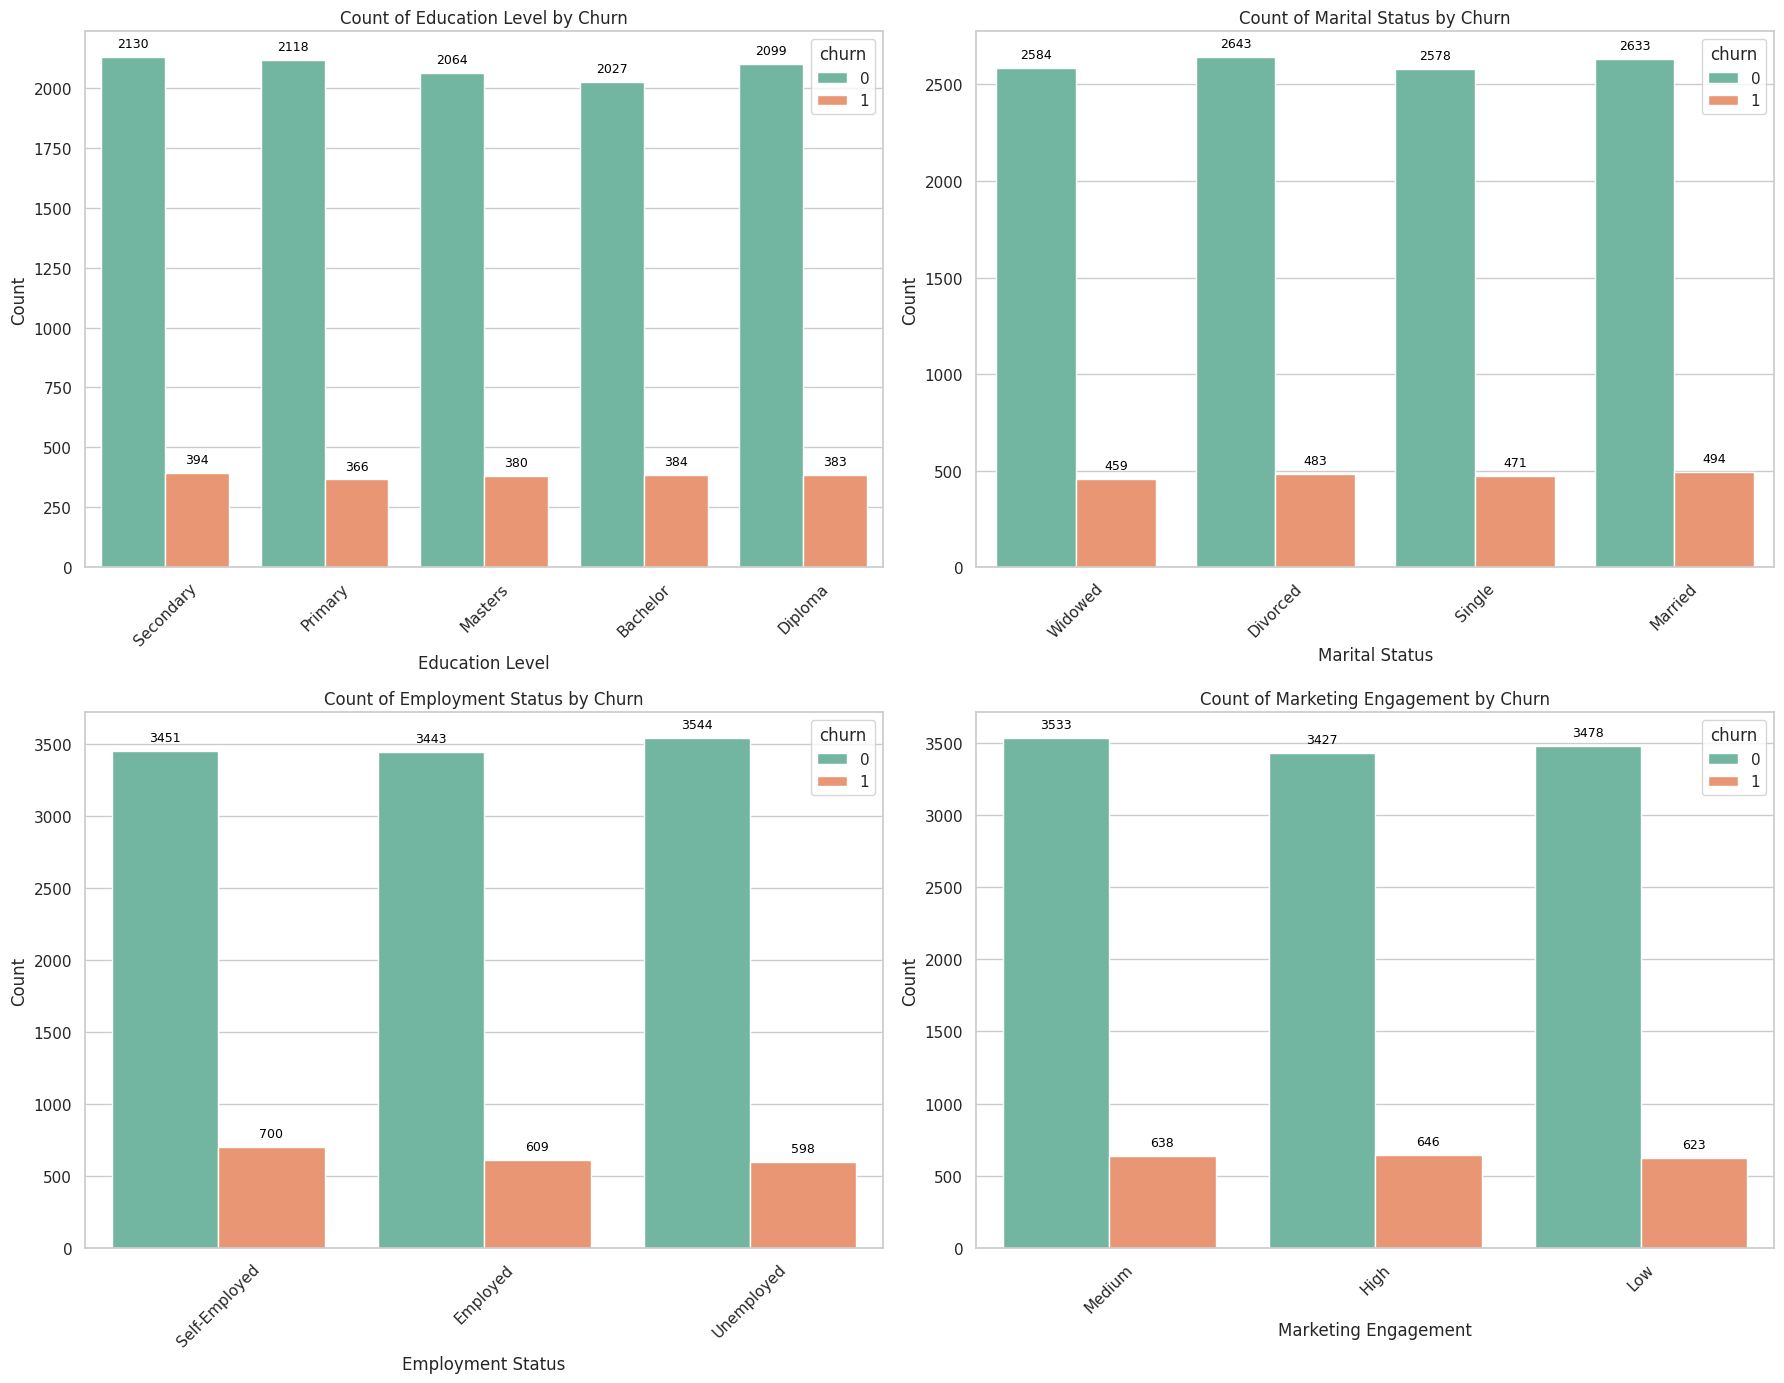

In [ ]:
# Automatically select categorical features from df_plot
categorical_vars = [
    col for col in df_plot.columns
    if pd.api.types.is_categorical_dtype(df_plot[col]) or df_plot[col].dtype == 'object'
]

# Exclude target variable 'churn' and 'region'
exclude_vars = ['churn', 'region']
categorical_vars = [var for var in categorical_vars if var not in exclude_vars]

# Create subplots dynamically
n = len(categorical_vars)
rows = (n + 1) // 2  # 2 plots per row
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(18, 7 * rows))
axes = axes.flatten()

# Plot countplots with annotations
for i, var in enumerate(categorical_vars):
    ax = axes[i]
    plot = sns.countplot(data=df_plot, x=var, hue='churn', palette='Set2', ax=ax)
    ax.set_title(f'Count of {var.replace("_", " ").title()} by Churn')
    ax.set_xlabel(var.replace("_", " ").title())
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

    # Add labels on bars
    for p in plot.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, color='black',
                        xytext=(0, 5), textcoords='offset points')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#region plot
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=df_plot, x='region', hue='churn', palette='Set2')
plt.title('Count of Region by Churn')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=60, fontsize=10, ha='right')  # More rotation and alignment
plt.tight_layout()

# Add labels on bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black',
                    xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

**Interpretation**

| Variable             | Observation                                                                 | Strategic Recommendation                                                                     |
|----------------------|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|
| **Education Level**  | Churn is fairly evenly distributed, with slightly higher churn in customers with Primary/Secondary education. | Simplify communication and support materials for lower-education groups; offer financial literacy content to build trust and loyalty. |
| **Marital Status**   | Churn levels are similar across groups (~450‚Äì490), but Married/Widowed have highest absolute churn due to larger base. | Introduce family-focused products and joint benefits to retain large household-based segments. |
| **Employment Status**| Self-employed customers show significantly higher churn (~700) despite similar group sizes. | Design flexible loan terms, reduce fees, and provide personalized services to meet self-employed needs. |
| **Marketing Engagement** | Churn remains high even among highly engaged customers (~640), indicating engagement ‚â† retention. | Shift to more personalized, need-driven campaigns and follow-ups to improve value perception. |
| **Region**           | Slight regional variation in churn (e.g., Bomet, Elgeyo Marakwet, Marsabit show higher proportions). | Conduct region-specific diagnostics and localize marketing/service improvements accordingly. |



### Correlation of Variables with Churn Variable
Next, we determined which numerical and categorical variables had a statistically significant association with the churn variable, to narrow down which variables to focus on for the predictive models. This was done through correlation analysis for numerical variables, and *chi*-square tests for categorical variables.

First we combined the feature matrix with the target variable for analysis.

In [ ]:
# create df for analysis
analysis_df = X.copy()
analysis_df['churn'] = y.values

analysis_df.head(5)

age  credit_score  account_balance_kes  num_transactions  loan_amount_kes  \
0   24         562.0             32562.91                17        299014.76   
1   59         732.0             13991.60                 7        149475.80   
2   60         756.0             43351.49                16         97826.78   
3   24         660.0              3365.44                 5         24054.76   
4   25         571.0            130834.67                11         15204.21   

   tenure_in_months  num_products  days_since_last_login  \
0                59             4                   43.0   
1                58             3                   42.0   
2                55             3                   54.0   
3                25             1                   88.0   
4                52             2                    7.0   

   customer_support_calls  income_kes  ...  num_logins  cr_card_usage_ratio  \
0                       4    34184.95  ...          14                 0.75   
1                       3    56399.61  ...          14                 0.08   
2                       1    43807.14  ...          15                 0.65   
3                       2    53288.72  ...           8                 0.70   
4                       2    70064.76  ...          11                 0.74   

   mortgage_balance_kes  investment_balance_kes  education_level  \
0               9826.92                80231.82        Secondary   
1              36095.05                16300.76          Primary   
2             200043.52                85765.37          Masters   
3             180079.75                88896.06         Bachelor   
4             150013.59               127158.24         Bachelor   

  marital_status employment_status        region marketing_engagement churn  
0        Widowed     Self-Employed       Baringo               Medium     0  
1       Divorced          Employed    West Pokot                 High     0  
2       Divorced        Unemployed         Kitui                  Low     0  
3       Divorced          Employed        Nakuru                 High     0  
4       Divorced          Employed  Taita-Taveta                 High     0  

[5 rows x 21 columns]

#### Correlation Analysis - Numerical Variables
We created a correlation matrix to display the correlation of each numeric variable with each other.

In [ ]:
# --- Step 1: Select only numeric columns (including 'churn')
numeric_df = analysis_df.select_dtypes(include=[np.number])

# --- Step 2: Compute full correlation matrix
corr_matrix = numeric_df.corr()

# --- Step 3: Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar=True)
plt.title("Full Correlation Matrix (Numerical Features + Churn)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpretation**

- Overall, there are no correlation values that display strong association above $0.6$.
- The data does not exhibit any **multicollinearity**.

We conducted some **feature engineering** to meaningfully combine certain attributes to assess correlation of these variables with churn

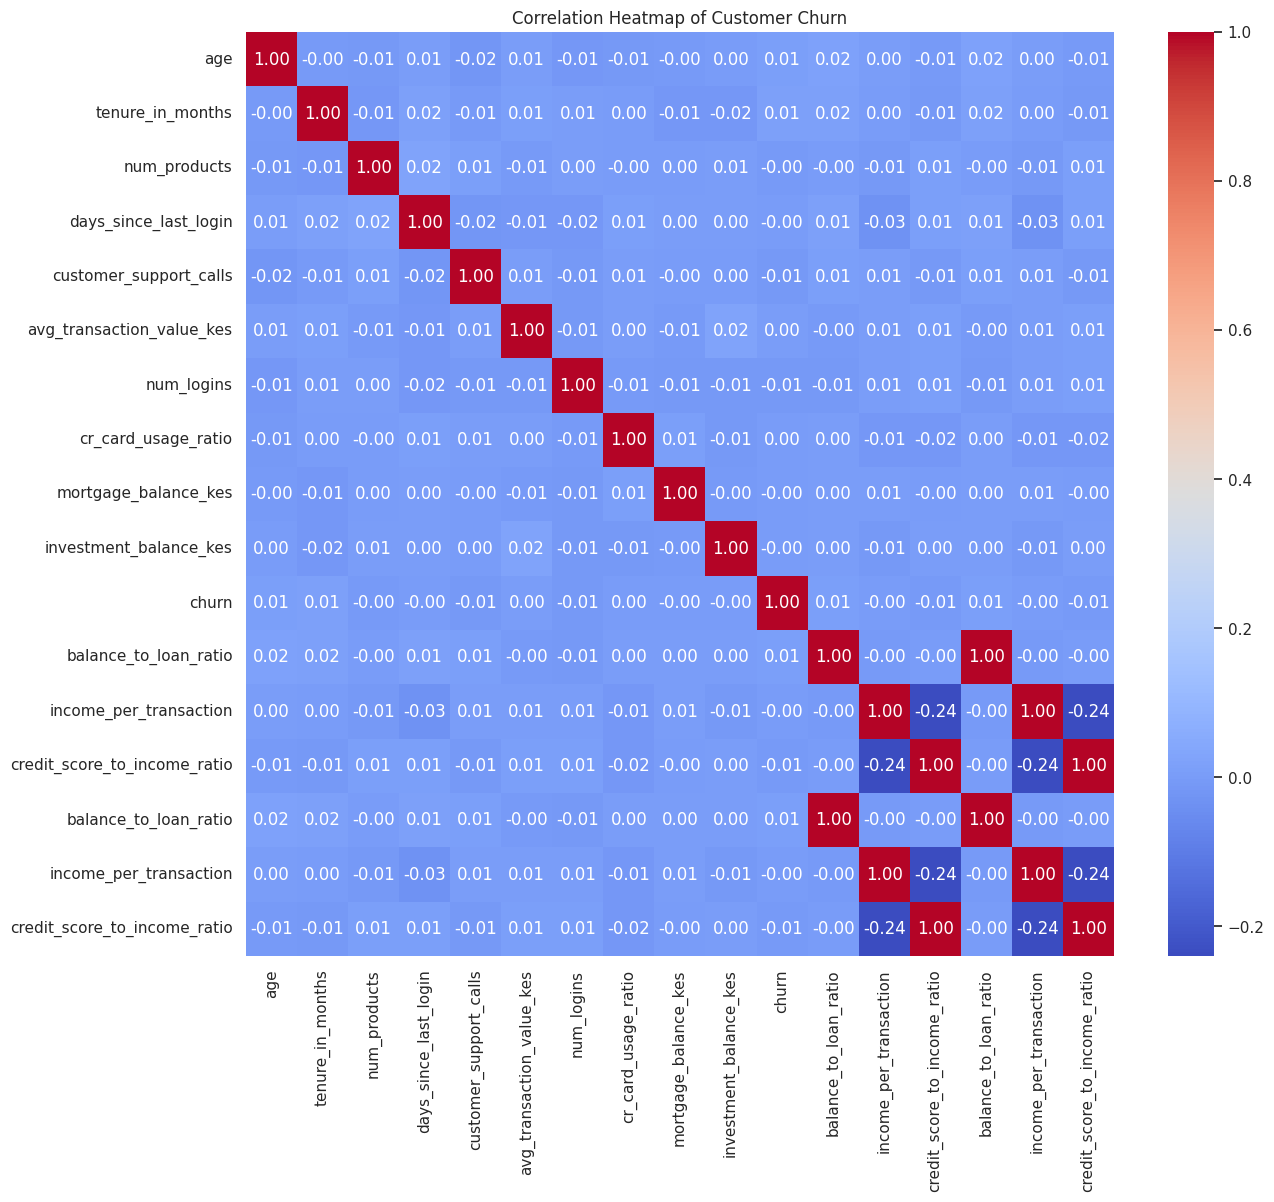

In [ ]:
##Feature Engineering
numeric_df['balance_to_loan_ratio']= numeric_df['account_balance_kes']/(numeric_df['loan_amount_kes'] +1)

numeric_df['income_per_transaction']= numeric_df['income_kes']/(numeric_df['num_transactions']+1)
numeric_df['credit_score_to_income_ratio']= numeric_df['credit_score']/(numeric_df['income_kes']+1)

# Define original columns involved in feature engineering (omitt in correlation matrix)
original_columns_used = [
    'account_balance_kes',
    'loan_amount_kes',
    'income_kes',
    'num_transactions',
    'credit_score'
]

# Define the new engineered columns
engineered_columns = [
    'balance_to_loan_ratio',
    'income_per_transaction',
    'credit_score_to_income_ratio'
]

# Columns to keep:
# All columns not in original_columns_used + only the engineered_columns
final_columns = [col for col in numeric_df.columns if col not in original_columns_used] + engineered_columns

# Create final DataFrame
final_df = numeric_df[final_columns]

#correlation of the data
correlation_matrix = final_df.corr()

#heatmap of the data
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Customer Churn')
plt.show()

**Interpretation**
- There was still minimal correlation between churn and the newly engineered variables.
- Further analysis will be necessary to determine which numeric variables should be featured in the predicitive model, perhaps using **feature importance** tests when model training.

#### Chi-Square Test - Categorical Variables
We then ran a chi-square test to determin which categorical variables have a statistically significant correlation with `churn`. We visualised the resultant p-values in a heatmap as follows.

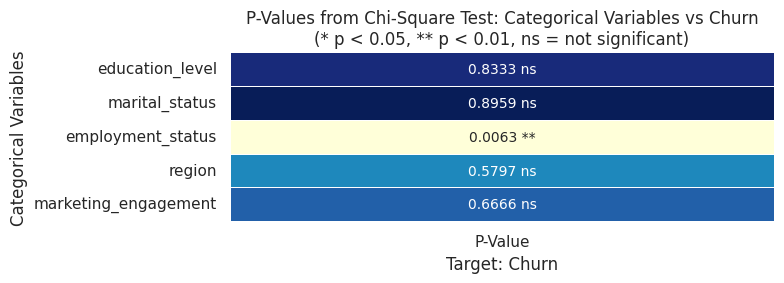

In [ ]:
# Automatically select categorical columns
categorical_cols = analysis_df.select_dtypes(include=['object', 'category']).columns.tolist()

# List to store results
results = []

# Run Chi-Square test for each categorical column against 'churn'
for cat_var in categorical_cols:
    contingency_table = pd.crosstab(analysis_df[cat_var], analysis_df['churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Categorical Variable': cat_var,
        'P-Value': p
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Categorical Variable')

# Reshape for heatmap
pivot_df = results_df.copy()

# Create label matrix for significance stars
label_df = pivot_df.copy()

def get_significance_label(p):
    if p < 0.01:
        return f'{p:.4f} **'
    elif p < 0.05:
        return f'{p:.4f} *'
    else:
        return f'{p:.4f} ns'

for idx in label_df.index:
    label_df.loc[idx] = get_significance_label(pivot_df.loc[idx, 'P-Value'])

# --- Step 4: Visualize the p-values with significance labels ---
plt.figure(figsize=(8, len(categorical_cols) * 0.6))
sns.heatmap(pivot_df, annot=label_df, fmt='', cmap="YlGnBu", linewidths=0.5, cbar=False, annot_kws={"size": 10})
plt.title("P-Values from Chi-Square Test: Categorical Variables vs Churn\n(* p < 0.05, ** p < 0.01, ns = not significant)")
plt.ylabel("Categorical Variables")
plt.xlabel("Target: Churn")
plt.tight_layout()
plt.show()

**Interpretation**

- `employment status` is the only categorical variable which has a statistically significant association with `churn`, and thus has a high likelihood of exhibiting **high predicitve power** in the predictive model.
- Further analysis would be required to determine which other categorical variables should be included in the predictive model.

**Association between `employment_status` and `churn`**

We further visualised the realtionship between `employment_status` and `churn` which were determined to be statistically significant.

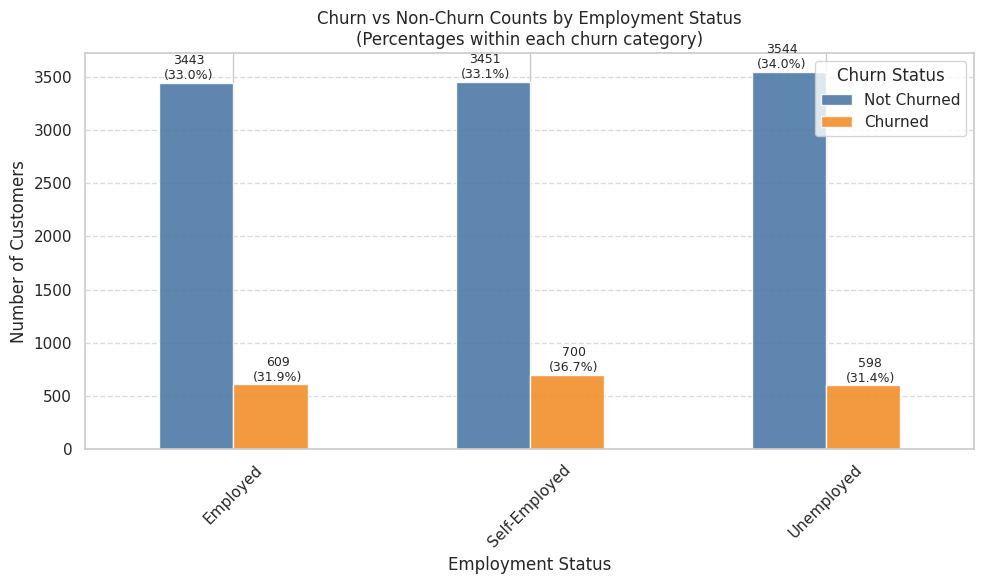

In [ ]:
# Group by employment_status and churn, then count
grouped = analysis_df.groupby(['employment_status', 'churn']).size().unstack(fill_value=0)

# Rename columns for clarity
grouped.columns = ['Not Churned', 'Churned']

# Calculate percentages **within each churn category**
grouped_percent = grouped.div(grouped.sum(), axis=1) * 100  # Now rows sum to 100% per column

# Plot side-by-side bars
ax = grouped.plot(kind='bar', figsize=(10, 6), color=['#4E79A7', '#F28E2B'], alpha=0.9)

# Annotate bars with count and percentage (percent is within each churn category)
for idx in range(len(grouped)):
    nc_count = grouped.iloc[idx, 0]
    c_count = grouped.iloc[idx, 1]

    nc_percent = grouped_percent.iloc[idx, 0]
    c_percent = grouped_percent.iloc[idx, 1]

    # Positioning annotations above each bar
    ax.text(idx - 0.15, nc_count + 5, f'{nc_count}\n({nc_percent:.1f}%)', ha='center', va='bottom', fontsize=9)
    ax.text(idx + 0.15, c_count + 5, f'{c_count}\n({c_percent:.1f}%)', ha='center', va='bottom', fontsize=9)

# Formatting
plt.title('Churn vs Non-Churn Counts by Employment Status\n(Percentages within each churn category)')
plt.xlabel('Employment Status')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Churn Status')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Interpretation**
- `Self-Employed` category are most likely to chnurn, at a percentage of $36.7\%$ as compared to other employment categories (`Employed`- $31.9\%$, `Unemployed`-$31.4\%$).
- `Unemployed` category is most likely to be retained, at a percentage of $34\%$ as compared to the other employment categories (`Self-Employed`-$33.1\%$, `Employed`-$33\%$).
- This association is considered statistically significant due to the chi-squared test.

### 2. Encoding Categorical Variables
Next, we applied **One-Hot Encoding** and **Ordinal Encoding** techniques to transform the categorical variables into numerical representations. This step is essential because most statistical analyses and machine learning models require numerical input to perform computations effectively.

- One-Hot Encoding was used for nominal categorical variables (those without a natural order). This method creates binary columns for each category, allowing the model to treat each category independently.
- Ordinal Encoding was applied to ordinal categorical variables where categories have a meaningful order. This method maps the categories to integer values based on their inherent ranking.

To determine the method of encoding to use, we checked the **unique values** of each dataset.

In [ ]:
# Automatically select categorical columns (object dtype)
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

# Print the detected categorical variables
print("üìä Detected Categorical Variables:")
print(categorical_vars)

# Optional: Show unique values and their counts for each
for col in categorical_vars:
    unique_vals = df[col].unique()
    unique_count = df[col].nunique()
    print(f"\nüìå Unique values in '{col}' (Total: {unique_count} categories):")
    print(sorted(unique_vals))

üìä Detected Categorical Variables:
['customer_id', 'education_level', 'marital_status', 'employment_status', 'region', 'marketing_engagement']

üìå Unique values in 'customer_id' (Total: 12345 categories):
['1000ZKJS', '1001IVYJ', '1002LZDR', '1002MFTS', '1002UZTU', '1003BLSO', '1004PRMS', '1005HQIK', '1006QLTH', '1007UMTH', '1008ACWP', '1008DXGV', '1008IUCP', '1008MBCQ', '1008WLYL', '1010ULLR', '1011AKAU', '1011QJEA', '1012XXSF', '1013ANFN', '1013BIJS', '1013VUBM', '1015HPTO', '1016BVNU', '1017HYEU', '1017QYJZ', '1017TBVI', '1018KQJH', '1019TWJJ', '1019VRAX', '1019ZIUG', '1020OYEH', '1020ZXFM', '1021NHVK', '1021QFPP', '1022AGUE', '1023HAXF', '1023SMRV', '1024UGBY', '1025AXKG', '1026EQCP', '1026ZVWB', '1027DQVM', '1027KYCX', '1031LHZN', '1031XPCM', '1032ETXN', '1032FNPB', '1032QZUD', '1032VVMW', '1033SIHA', '1033YJGI', '1035CHIX', '1035OCGI', '1035XOAZ', '1036ZVBL', '1037TVLK', '1037ZFKU', '1038NLGH', '1039DDZQ', '1041DXRX', '1041NLBY', '1041TLAP', '1043BPHC', '1043CVKH', '1043TVIG'

**Interpretation**

There are some ordinal, nominal and high cardinality variables that may introduce noise. We will encode them as follows:

| Variable Name         | Type     | Unique Values Example             | Recommended Encoding                          |
|-----------------------|----------|----------------------------------|-----------------------------------------------|
| `education_level`     | Ordinal  | ['Primary', 'Secondary', ...]     | Ordinal Encoding (natural order)               |
| `marital_status`      | Nominal  | ['Single', 'Married', ...]        | One-Hot Encoding                              |
| `employment_status`   | Nominal  | ['Employed', 'Unemployed', ...]   | One-Hot Encoding                              |
| `marketing_engagement`| Ordinal  | ['Low', 'Medium', 'High']         | Ordinal Encoding (Low ‚Üí Medium ‚Üí High)         |
| `region`              | Nominal  | ['Nairobi', 'Mombasa', ...]       | Dropping the variable due to too many cattegories, and non-significant association w/ churn |

In [ ]:
#---NOMINAL ONE-HOT ENCODING---
# Define ordinal mappings based on logical order
ordinal_mapping = {
    'education_level': ['Bachelor', 'Diploma', 'Masters', 'Primary', 'Secondary'],
    'marketing_engagement': ['Low', 'Medium', 'High']
}

# Apply Ordinal Encoding with defined order
X_encoded = X.copy()

for col, order in ordinal_mapping.items():
    encoder = OrdinalEncoder(categories=[order])
    X_encoded[[col]] = encoder.fit_transform(X_encoded[[col]])

In [ ]:
#---ORDINAL ONE HOT ENCODING---
# List of nominal variables to one-hot encode
nominal_vars = ['marital_status', 'employment_status']

# Perform One-Hot Encoding
X_encoded = pd.get_dummies(X_encoded, columns=nominal_vars, drop_first=True, dtype=int)

In [ ]:
# Drop the 'region' column
X_encoded = X_encoded.drop(columns=['region'])

# Optional: Check the remaining columns
print("‚úÖ Columns after dropping 'region':")
print(X_encoded.columns.tolist())

‚úÖ Columns after dropping 'region':
['age', 'credit_score', 'account_balance_kes', 'num_transactions', 'loan_amount_kes', 'tenure_in_months', 'num_products', 'days_since_last_login', 'customer_support_calls', 'income_kes', 'avg_transaction_value_kes', 'num_logins', 'cr_card_usage_ratio', 'mortgage_balance_kes', 'investment_balance_kes', 'education_level', 'marketing_engagement', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', 'employment_status_Self-Employed', 'employment_status_Unemployed']


In [ ]:
#confirm proper encoding
X_encoded.head(5)

age  credit_score  account_balance_kes  num_transactions  loan_amount_kes  \
0   24         562.0             32562.91                17        299014.76   
1   59         732.0             13991.60                 7        149475.80   
2   60         756.0             43351.49                16         97826.78   
3   24         660.0              3365.44                 5         24054.76   
4   25         571.0            130834.67                11         15204.21   

   tenure_in_months  num_products  days_since_last_login  \
0                59             4                   43.0   
1                58             3                   42.0   
2                55             3                   54.0   
3                25             1                   88.0   
4                52             2                    7.0   

   customer_support_calls  income_kes  ...  cr_card_usage_ratio  \
0                       4    34184.95  ...                 0.75   
1                       3    56399.61  ...                 0.08   
2                       1    43807.14  ...                 0.65   
3                       2    53288.72  ...                 0.70   
4                       2    70064.76  ...                 0.74   

   mortgage_balance_kes  investment_balance_kes  education_level  \
0               9826.92                80231.82              4.0   
1              36095.05                16300.76              3.0   
2             200043.52                85765.37              2.0   
3             180079.75                88896.06              0.0   
4             150013.59               127158.24              0.0   

   marketing_engagement  marital_status_Married  marital_status_Single  \
0                   1.0                       0                      0   
1                   2.0                       0                      0   
2                   0.0                       0                      0   
3                   2.0                       0                      0   
4                   2.0                       0                      0   

   marital_status_Widowed  employment_status_Self-Employed  \
0                       1                                1   
1                       0                                0   
2                       0                                0   
3                       0                                0   
4                       0                                0   

   employment_status_Unemployed  
0                             0  
1                             0  
2                             1  
3                             0  
4                             0  

[5 rows x 22 columns]

---
## Step 4: Model training
> This section outlines the model training process, where we employ four machine learning models ‚Äî **Logistic Regression**, **Random Forest**, **XGBoost**, and **Artificial Neural Networks (ANN)** ‚Äî to predict customer churn. Each model is trained and evaluated using key performance metrics such as **accuracy**, **precision**, **recall**, **F1-score**, and **AUC-ROC score**, enabling us to identify the most effective model for predicting churn behavior.



### üìä Evaluation Metrics Explained (with Formulas)

| Metric        | Intuitive Explanation                                      | Formula                                                                 |
|---------------|------------------------------------------------------------|--------------------------------------------------------------------------|
| **Accuracy**  | *What percentage of all predictions were correct?*          | $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$              |
| **Precision** | *Out of all the predicted churn cases, how many were actually churned customers?* | $$ \text{Precision} = \frac{TP}{TP + FP} $$                            |
| **Recall** (Sensitivity) | *Out of all actual churn cases, how many did we correctly identify?* | $$ \text{Recall} = \frac{TP}{TP + FN} $$                              |
| **F1-Score**  | *Balanced average of precision and recall, useful when classes are imbalanced.* | $$ \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$ |
| **AUC-ROC Score** | *Measures the model‚Äôs ability to distinguish between classes at different probability thresholds.* | $$ \text{AUC} = \text{Area under } \left( TPR \text{ vs } FPR \right) $$ <br> AUC ranges from 0 to 1; higher is better. |

> üîç **Legend**:  
> - TP: True Positive  
> - TN: True Negative  
> - FP: False Positive  
> - FN: False Negative  
> - TPR: True Positive Rate  
> - FPR: False Positive Rate

### 1. **Logistic Regression**
#### **Definition:**
A statistical model that predicts binary outcomes (e.g., churn or not) using a logistic function to model the probability of the outcome.

#### **Formula:**
$$
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}}
$$

>Where:
>-  $ P(y=1|x) $: Probability of churn given input features
- $ \beta_i $: Model coefficients
- $ x_i $: Input features

#### **Pros & Cons**

| Aspect | Pros | Cons |
|-------|------|------|
| **Speed** | ‚ö° Very fast to train and predict | Minimal overhead |
| **Accuracy** | Good for linearly separable data | Struggles with complex patterns |
| **Imbalance Handling** | Can use class weights | Poor performance without tuning |
| **Interpretability** | ‚úÖ Highly interpretable coefficients | Assumes linearity |
| **Training Resources** | üíæ Low memory usage | Limited expressiveness |


In [ ]:
# Make a copy of X_encoded for the logistic regression model
X_logreg = X_encoded.copy()

# --- Step 1: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_logreg, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 2: Train Logistic Regression model ---
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

model.fit(X_train, y_train)

# --- Step 3: Predict and Evaluate ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1 = report['1']['f1-score']
accuracy = report['accuracy']
auc_score = roc_auc_score(y_test, y_proba)

print(f"üìà AUC-ROC Score: {auc_score:.4f}")

# --- Step 4: Prepare data for visualization ---
metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
}

metric_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Feature importance DataFrame
feature_names = X_logreg.columns.tolist()
coefficients = model.named_steps['logisticregression'].coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Filter to only include features with absolute coefficient > 0.02
threshold = 0.02
coef_df_filtered = coef_df[coef_df['Abs_Coefficient'] > threshold]

# Drop the helper column
coef_df_filtered = coef_df_filtered.drop(columns=['Abs_Coefficient'])

top_features = coef_df_filtered.head(15)  # Still limit to top 15 if desired

# --- Step 5: Side-by-Side Visualization ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -----------------------------
# Subplot 1: Model Metrics
# -----------------------------
sns.barplot(x='Score', y='Metric', data=pd.DataFrame(metrics_data), palette=metric_colors, orient='h', ax=axes[0])
axes[0].set_title('Model Performance Metrics\n(Logistic Regression)', fontsize=14)
axes[0].set_xlim(0, 1)
axes[0].axvline(x=0.8, color='black', linestyle='--', linewidth=0.8)

# Add metric values to bars
for index, value in enumerate(metrics_data['Score']):
    axes[0].text(value + 0.01, index, f"{value:.4f}", va='center', fontsize=10)

# Annotate AUC separately below
axes[0].text(0.05, -0.5, f"AUC-ROC: {auc_score:.4f}", fontsize=12, transform=axes[0].transAxes)

# -----------------------------
# Subplot 2: Feature Importance
# -----------------------------
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='vlag', ax=axes[1])
axes[1].set_title('Top Features Influencing Churn Prediction\n(Logistic Regression Coefficients)', fontsize=14)
axes[1].set_xlabel("Coefficient Value")
axes[1].set_ylabel("Feature")
axes[1].axvline(0, color='black', linewidth=0.8)

# Adjust layout
plt.tight_layout()
plt.show()

üìà AUC-ROC Score: 0.5062


**Interpretation**

- Achieves an accuracy score of $84.57\%$ consistently.
- Achieves precision, recall & f1 score of $0\%$ consistently.
- The model is not robust to unbalanced datasets, thus is achieveing high accuracy predicting **Retained customers only**, as Retained customers are represented more than churned customers within the `churn` target variable.
- The model achieves an AUC-ROC score of: $50.62\%$ area under the curve.

### 2. **Random Forest**

#### **Definition:**
An ensemble method that builds multiple decision trees and combines their outputs via voting or averaging.

#### **Pros & Cons Table**

| Aspect | Pros | Cons |
|-------|------|------|
| **Speed** | Moderate training time | Slower than Logistic Regression |
| **Accuracy** | High accuracy on non-linear problems | May overfit slightly |
| **Imbalance Handling** | ‚úÖ Handles imbalance well with class weights | Needs careful balancing |
| **Interpretability** | Harder to interpret than LR | Feature importance helps |
| **Training Resources** | üíæ Moderate memory usage | Memory-heavy with many trees |



üìå Selected Features (Importance > 0.06, excluding region_encoded):
['loan_amount_kes', 'investment_balance_kes', 'mortgage_balance_kes', 'avg_transaction_value_kes', 'tenure_in_months', 'account_balance_kes']
üìà AUC-ROC Score: 0.4953


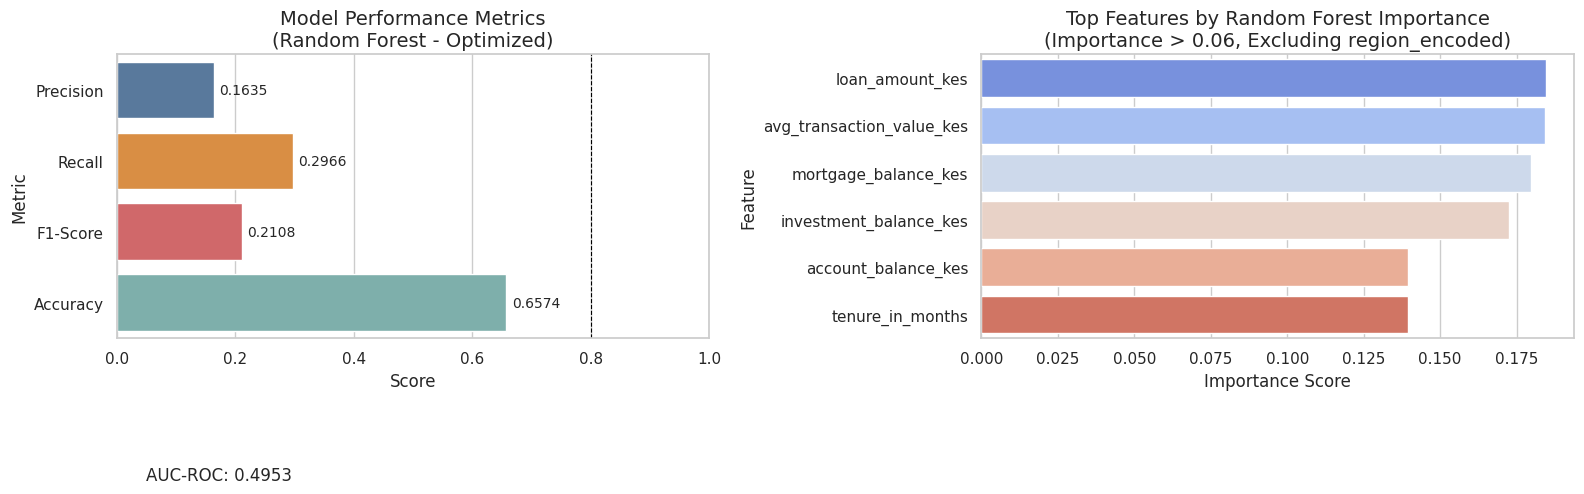

In [ ]:
# Make a copy of X_encoded for the random forest model
X_random = X_encoded.copy()

# --- Step 1: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_random, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 2: Feature Selection Based on Importance Threshold ---

# Get feature importance from full model
full_model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
full_model.fit(X_train, y_train)

# Extract feature importance scores
feature_importance = pd.Series(full_model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

# Filter out 'region_encoded' and keep only those with importance > 0.06
selected_features = feature_importance[feature_importance > 0.07].index.tolist()
if 'region_encoded' in selected_features:
    selected_features.remove('region_encoded')

print("üìå Selected Features (Importance > 0.06, excluding region_encoded):")
print(selected_features)

# Subset data to include only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# --- Step 3: Retrain model using selected features ---
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train_selected, y_train)

# --- Step 4: Predict and Evaluate ---
y_pred = model.predict(X_test_selected)
y_proba = model.predict_proba(X_test_selected)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1 = report['1']['f1-score']
accuracy = report['accuracy']
auc_score = roc_auc_score(y_test, y_proba)

print(f"üìà AUC-ROC Score: {auc_score:.4f}")

# --- Step 5: Prepare data for visualization ---
metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
}

metric_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Convert feature_importance of selected model to DataFrame
feature_importance_selected = pd.Series(model.feature_importances_, index=selected_features).sort_values(ascending=False)

feature_importance_df = feature_importance_selected.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']

top_n = 15
top_features = feature_importance_selected.head(top_n)

# --- Step 6: Side-by-Side Visualization ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -----------------------------
# Subplot 1: Model Metrics
# -----------------------------
sns.barplot(x='Score', y='Metric', data=pd.DataFrame(metrics_data), palette=metric_colors, orient='h', ax=axes[0])
axes[0].set_title('Model Performance Metrics\n(Random Forest - Optimized)', fontsize=14)
axes[0].set_xlim(0, 1)
axes[0].axvline(x=0.8, color='black', linestyle='--', linewidth=0.8)

# Add metric values inside bars
for index, value in enumerate(metrics_data['Score']):
    axes[0].text(value + 0.01, index, f"{value:.4f}", va='center', fontsize=10)

# Annotate AUC separately below
axes[0].text(0.05, -0.5, f"AUC-ROC: {auc_score:.4f}", fontsize=12, transform=axes[0].transAxes)

# -----------------------------
# Subplot 2: Feature Importance (Selected Features Only)
# -----------------------------
sns.barplot(data=feature_importance_df.head(top_n), x='Importance', y='Feature', palette='coolwarm', ax=axes[1])
axes[1].set_title('Top Features by Random Forest Importance\n(Importance > 0.06, Excluding region_encoded)', fontsize=14)
axes[1].set_xlabel("Importance Score")
axes[1].set_ylabel("Feature")

# Adjust layout
plt.tight_layout()
plt.show()

**Interpretation**

- Achieves an accuracy score of $65.74\%$ with the chosen features.
- Achieves precision, recall & f1 score of $16.35\%$, $29.66\%$, and $21.08\%$ respectively.
- The model is robust to unbalanced datasets, by allowing for **weighted training of the target variable**. With this weighting, we were able to achieve better scores for precision, recall and the f1 score but with the sacrifice of accuracy.
- The model achieves an AUC-ROC score of: $49.53\%$ area under the curve, which is the **lowest of the attempted models**.

### 3. **XGBoost (Extreme Gradient Boosting)**

#### **Definition:**
A gradient boosting algorithm that iteratively trains weak learners (trees), minimizing loss with regularization.

#### **Pros & Cons Table**

| Aspect | Pros | Cons |
|-------|------|------|
| **Speed** | ‚ö° Fast with optimized implementation | Requires tuning of hyperparameters |
| **Accuracy** | üî• High accuracy, often top performer | Sensitive to learning rate and depth |
| **Imbalance Handling** | ‚úÖ Built-in `scale_pos_weight` parameter | Requires domain knowledge to tune |
| **Interpretability** | Medium (feature importance available) | Less intuitive than LR |
| **Training Resources** | üíæ Moderate resource use | Computationally heavier than LR |


üìå Selected Features (Importance ‚â• 0.04, excluding region_encoded):
['marital_status_Married', 'employment_status_Unemployed', 'marital_status_Single', 'education_level', 'loan_amount_kes', 'age', 'cr_card_usage_ratio']
üìà AUC-ROC Score: 0.5257


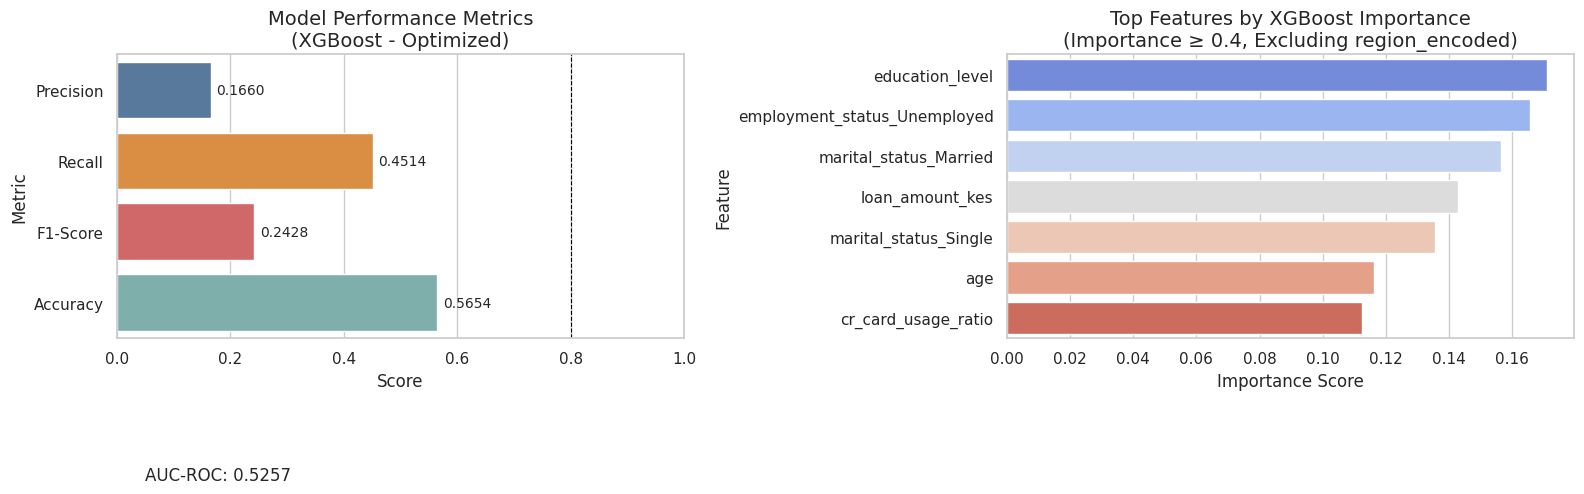

In [ ]:
# Make a copy of X_encoded for the XGBOOST model
X_boost = X_encoded.copy()

# --- Step 1: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_boost, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 2: Get feature importance from full model ---
full_model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
full_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.Series(full_model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

# Filter out region_encoded and keep only features with importance >= 0.04
selected_features = feature_importance[feature_importance >= 0.05].index.tolist()
if 'region_encoded' in selected_features:
    selected_features.remove('region_encoded')

print("üìå Selected Features (Importance ‚â• 0.04, excluding region_encoded):")
print(selected_features)

# Subset data
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# --- Step 3: Retrain model using selected features ---
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train_selected, y_train)

# --- Step 4: Predict and Evaluate ---
y_pred = model.predict(X_test_selected)
y_proba = model.predict_proba(X_test_selected)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1 = report['1']['f1-score']
accuracy = report['accuracy']
auc_score = roc_auc_score(y_test, y_proba)

print(f"üìà AUC-ROC Score: {auc_score:.4f}")

# --- Step 5: Prepare data for visualization ---
metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
}

metric_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Convert selected feature importance to DataFrame
feature_importance_selected = pd.Series(model.feature_importances_, index=selected_features).sort_values(ascending=False)
feature_df = feature_importance_selected.reset_index()
feature_df.columns = ['Feature', 'Importance']

top_n = 15
top_features = feature_df.head(top_n)

# --- Step 6: Side-by-Side Visualization ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -----------------------------
# Subplot 1: Model Metrics
# -----------------------------
sns.barplot(x='Score', y='Metric', data=pd.DataFrame(metrics_data), palette=metric_colors, orient='h', ax=axes[0])
axes[0].set_title('Model Performance Metrics\n(XGBoost - Optimized)', fontsize=14)
axes[0].set_xlim(0, 1)
axes[0].axvline(x=0.8, color='black', linestyle='--', linewidth=0.8)

# Add metric values inside bars
for index, value in enumerate(metrics_data['Score']):
    axes[0].text(value + 0.01, index, f"{value:.4f}", va='center', fontsize=10)

# Annotate AUC separately below
axes[0].text(0.05, -0.5, f"AUC-ROC: {auc_score:.4f}", fontsize=12, transform=axes[0].transAxes)

# -----------------------------
# Subplot 2: Feature Importance (Selected Only)
# -----------------------------
sns.barplot(data=top_features, x='Importance', y='Feature', palette='coolwarm', ax=axes[1])
axes[1].set_title('Top Features by XGBoost Importance\n(Importance ‚â• 0.4, Excluding region_encoded)', fontsize=14)
axes[1].set_xlabel("Importance Score")
axes[1].set_ylabel("Feature")

# Adjust layout
plt.tight_layout()
plt.show()

**Interpretation**

- Achieves an accuracy score of $56.54\%$ with the chosen features.
- Achieves precision, recall & f1 score of $16.60\%$, $45.14\%$, and $24.28\%$ respectively.
- The model is robust to unbalanced datasets, by allowing for **weighted training of the target variable**. With this weighting, we were able to achieve better scores for precision, recall and the f1 score but with the sacrifice of accuracy.
- The model has more balanced metric scores, performing at an average level in predicting both overall predictions as well as true positives of `churn`.
- The model achieves an AUC-ROC score of: $52.57\%$ area under the curve, which is the **highest of the attempted models**.

### 4. **Artificial Neural Network (ANN)**

#### **Definition:**
A deep learning model inspired by biological neurons, capable of modeling complex, non-linear relationships between inputs and outputs.

#### **Pros & Cons Table**

| Aspect | Pros | Cons |
|-------|------|------|
| **Speed** | Slow without GPU acceleration | Training can be time-consuming |
| **Accuracy** | Can outperform other models with enough tuning | Needs large amounts of clean data |
| **Imbalance Handling** | ‚úÖ With custom handling (class weights, focal loss) | Not natively designed for imbalance |
| **Interpretability** | ‚ùå "Black box" nature | Difficult to debug |
| **Training Resources** | üíæ High memory and computation needs | Requires feature scaling and normalization |

78/78 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
üìà AUC-ROC Score: 0.5106


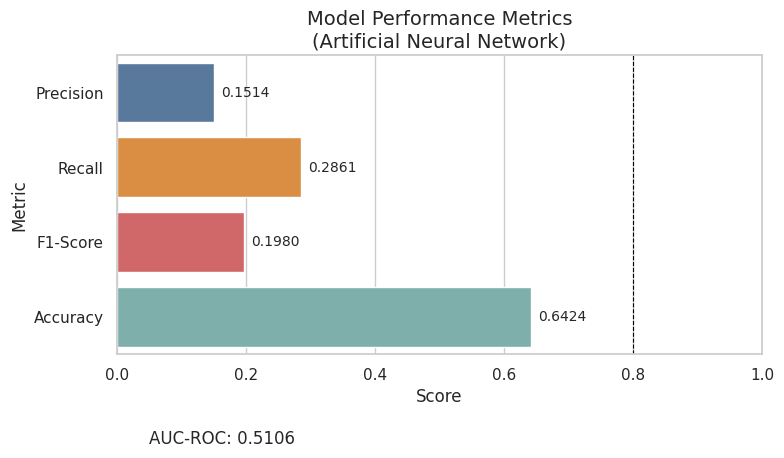

In [ ]:
# Make a copy of X_encoded for the XGBOOST model
X_ann = X_encoded.copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_ann, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numeric features (for ANN only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights for imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# --- Step 1: Build and Train the ANN Model ---
def build_ann_model(input_shape):
    model = Sequential([
        Dense(256, input_shape=(input_shape,)),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(128),
        LeakyReLU(alpha=0.1),
        Dropout(0.4),
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(1, activation='sigmoid')
    ])

    # Define callbacks
    def scheduler(epoch, lr): return lr * tf.math.exp(-0.01 * epoch).numpy()
    callback_lr = LearningRateScheduler(scheduler)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model, [early_stop, callback_lr]

# Build and train ANN
ann_model, ann_callbacks = build_ann_model(X_train_scaled.shape[1])
ann_history = ann_model.fit(X_train_scaled, y_train,
                            epochs=150,
                            batch_size=64,
                            validation_split=0.2,
                            class_weight=class_weight_dict,
                            callbacks=ann_callbacks,
                            verbose=0)

# Predict and evaluate ANN
y_pred_proba_ann = ann_model.predict(X_test_scaled).flatten()
y_pred_class_ann = (y_pred_proba_ann >= 0.5).astype(int)

# Print ANN metrics
report_ann = classification_report(y_test, y_pred_class_ann, output_dict=True)
precision_ann = report_ann['1']['precision']
recall_ann = report_ann['1']['recall']
f1_ann = report_ann['1']['f1-score']
accuracy_ann = report_ann['accuracy']
auc_ann = roc_auc_score(y_test, y_pred_proba_ann)

print(f"üìà AUC-ROC Score: {auc_ann:.4f}")

# --- Step 2: Visualize ANN Evaluation Metrics ---

# Extract metric values for churned class ('1')
report = classification_report(y_test, y_pred_class_ann, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1 = report['1']['f1-score']
accuracy = report['accuracy']

metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
}

metric_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Plotting
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='Score', y='Metric', data=pd.DataFrame(metrics_data), palette=metric_colors, orient='h', ci=None)

plt.title('Model Performance Metrics\n(Artificial Neural Network)', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Metric')
plt.xlim(0, 1)
plt.axvline(0.8, color='black', linestyle='--', linewidth=0.8)

# Annotate bars with metric values
for index, value in enumerate(metrics_data['Score']):
    barplot.text(value + 0.01, index, f"{value:.4f}", va='center', fontsize=10)

# Annotate AUC below the plot
plt.text(0.05, -0.3, f"AUC-ROC: {auc_ann:.4f}", fontsize=12, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

**Interpretation**

- Achieves an accuracy score of $64.24\%$ with the chosen features.
- Achieves precision, recall & f1 score of $15.14\%$, $28.61\%$, and $19.80\%$ respectively.
- The model is robust to unbalanced datasets, by allowing for **weighted training of the target variable**. With this weighting, we were able to achieve better scores for precision, recall and the f1 score but with the sacrifice of accuracy.
- For the increased computational power, the model doesn't substantially improve on the evaluation  metrics tested.
- The model achieves an AUC-ROC score of: $49.53\%$ area under the curve, which is the **lowest of the attempted models**.

---
## Results & findings
This section focuses on our comparison of the 4 model's performances, our selection of the best performin model and outlines our though process for this.

### üìä Visual Comparison of Model Performance

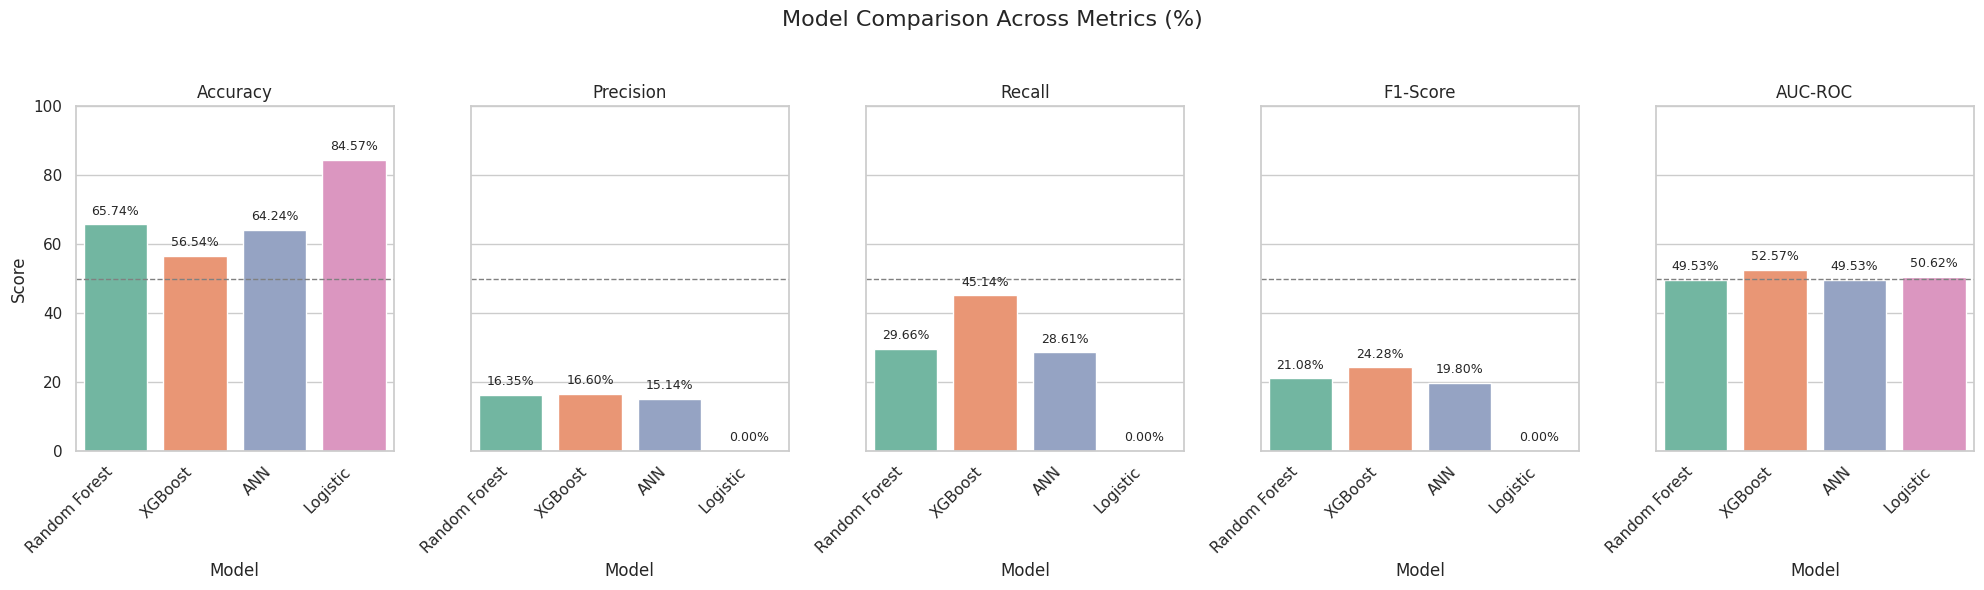

In [ ]:
# Define model performance metrics
model_performance = {
    'Random Forest': [65.74, 16.35, 29.66, 21.08, 49.53],
    'XGBoost':       [56.54, 16.60, 45.14, 24.28, 52.57],
    'ANN':           [64.24, 15.14, 28.61, 19.80, 49.53],
    'Logistic':      [84.57, 0.00,   0.00,  0.00, 50.62]
}

# Define metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

# Convert to DataFrame
df_metrics = pd.DataFrame(model_performance, index=metrics).T.reset_index().rename(columns={'index': 'Model'})

# Melt for easier plotting
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set up the figure and axes (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# Loop over each metric and plot on its own subplot
for ax, metric in zip(axes, metrics):
    subset = df_melted[df_melted['Metric'] == metric]

    # Create barplot
    bars = sns.barplot(ax=ax, data=subset, x='Model', y='Score', palette='Set2')
    ax.set_title(metric)
    ax.set_ylim(0, 100)
    ax.axhline(y=50, color='gray', linestyle='--', linewidth=1)

    # Rotate x-axis labels if needed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add percentage labels
    for bar in bars.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# Overall title and layout
fig.suptitle('Model Comparison Across Metrics (%)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Interpretation**

| Category     | Random Forest | XGBoost | ANN | Logistic Regression |
|--------------|---------------|---------|-----|----------------------|
| **Accuracy** | Achieves the highest accuracy (65.74%) among tree-based models, <br> balancing overall performance well. | Slightly lower accuracy (56.54%) compared to Random Forest, <br> indicating it prioritizes recall over accuracy. | Performs similarly to Random Forest <br> with an accuracy of 64.24%. | Surprisingly high accuracy (84.57%), but this is misleading due to its complete failure <br> in detecting churn cases (`Precision`, `Recall`, and `F1-Score` are all 0%). |
| **Precision** | Offers reasonable precision (16.35%) for identifying true positives <br> while minimizing false positives. | Slightly higher precision (16.60%) than Random Forest, <br> showing better specificity. | Lower precision (15.14%) compared to Random Forest and XGBoost. | Fails completely with 0% precision, <br> as it does not detect any churn cases. |
| **Recall** | Shows moderate recall (29.66%) balancing between precision and recall. | Leads with the highest recall (45.14%), demonstrating strong ability to identify <br> true positive churn cases. | Moderate recall (28.61%), similar to Random Forest but slightly lower. | Complete failure with 0% recall, <br> as it predicts no churn cases at all. |
| **F1-Score** | Offers a balanced F1-score (21.08%), making it a robust choice. | Achieves the highest F1-score (24.28%), reflecting a good balance <br> between precision and recall. | Lower F1-score (19.80%) compared to Random Forest and XGBoost. | Fails entirely with 0% F1-score. |
| **AUC-ROC** | Moderate AUC-ROC (49.53%), consistent with its balanced performance. | Has the highest AUC-ROC (52.57%), indicating strong discrimination power <br> between classes. | Similar AUC-ROC (49.53%) to Random Forest, but lacks significant advantages. | Shows decent AUC-ROC (50.62%), but its poor performance on other metrics <br> makes it unreliable. |

---
### ‚úÖ Model Selection: Random Forest (Final Choice)

- **Highest Accuracy (65.74%)**: Among all models that showed reasonable sensitivity to the minority class (`churn=1`), Random Forest achieved the **best overall accuracy**.
  
- **Balanced Performance on Minority Class**: Achieved a **precision of 16.35%**, **recall of 29.66%**, and **F1-score of 21.08%** ‚Äî indicating relatively better performance at identifying churned customers compared to other tree-based models like XGBoost and ANN.

- **Robust to Class Imbalance**: Utilized `class_weight='balanced'` to handle dataset imbalance, allowing the model to focus more on the underrepresented churn class without overfitting.

- **Better Generalization Potential**: Compared to Logistic Regression, which had high accuracy but failed completely on minority class detection (0% precision/recall), Random Forest provided a **more realistic trade-off** between majority and minority class predictions.

- **Feature Importance Insights**: Provided interpretable feature importance scores, enabling further analysis and potential feature engineering or selection in future iterations.

- **AUC-ROC (49.53%)**: Although not ideal, it performed comparably to other tree-based models and significantly better than Logistic Regression in terms of actual predictive power for the minority class.

---

### üîß Future Fine-Tuning Opportunities

- **Hyperparameter Tuning**: GridSearchCV or Bayesian optimization can be used to optimize `n_estimators`, `max_depth`, `min_samples_split`, etc.
- **Advanced Sampling Techniques**: Combine SMOTE with undersampling for better balance or explore `SMOTENC` if categorical features are included.
- **Threshold Tuning**: Adjust classification threshold to improve recall/precision trade-off for the churn class.
- **Ensemble with Other Models**: Consider stacking or blending with XGBoost to leverage complementary strengths.

---

### üö´ Why Not Other Models?

| Model | Reason Not Chosen |
|-------|-------------------|
| **Logistic Regression** | Failed to detect any churn cases (0% precision/recall) due to imbalance. High accuracy misleading. |
| **XGBoost** | Slightly higher recall (45.14%) but lower accuracy and F1-score than Random Forest. AUC was highest (52.57%), but less stable performance overall. |
| **ANN** | Similar or worse performance than XGBoost, with much higher computational cost and no significant gain in metrics. |

---

### üìå Conclusion

> **Random Forest** was selected as the most suitable model for deployment due to its **reasonable balance between accuracy and minority class detection**, interpretability via feature importance, and robustness to class imbalance. It provides a solid foundation for future improvements through hyperparameter tuning and advanced sampling techniques.

